## Read input

In [422]:
import random

with open('dataset/cryptominer_commands.txt', 'r', encoding='utf-8') as f:
    crypto_lines = f.readlines()

with open('dataset/non_cryptominer_commands.txt', 'r', encoding='utf-8') as f:
    noncrypto_lines = f.readlines()

random.shuffle(crypto_lines)
random.shuffle(noncrypto_lines)

len(crypto_lines), len(noncrypto_lines)

(56, 100)

## Tokenisation and training split

In [423]:
import torch
import tiktoken
enc = tiktoken.get_encoding("gpt2")

command_max_tokens = 200

def convert_lines_to_token_tensors(lines,): 
    data = [enc.encode(line) for line in lines]
    padded_lists = [lst + [0] * (command_max_tokens - len(lst)) for lst in data]

    tensor_data = torch.tensor(padded_lists).long()
    return tensor_data

X = convert_lines_to_token_tensors(crypto_lines + noncrypto_lines)
Y = torch.cat([torch.ones(len(crypto_lines)), torch.zeros(len(noncrypto_lines))])

train_ratio = 0.8
crypto_lines_train_length = int(len(crypto_lines) * train_ratio)
noncrypto_lines_train_length = int(len(crypto_lines) * train_ratio)

crypto_lines_train, crypto_lines_validation = crypto_lines[:crypto_lines_train_length], crypto_lines[crypto_lines_train_length:]
noncrypto_lines_train, noncrypto_lines_validation = noncrypto_lines[:noncrypto_lines_train_length], noncrypto_lines[noncrypto_lines_train_length:]

X_train = convert_lines_to_token_tensors(crypto_lines_train + noncrypto_lines_train)
Y_train = torch.cat([torch.ones(len(crypto_lines_train)), torch.zeros(len(noncrypto_lines_train))])

X_validation = convert_lines_to_token_tensors(crypto_lines_validation + noncrypto_lines_validation)
Y_validation = torch.cat([torch.ones(len(crypto_lines_validation)), torch.zeros(len(noncrypto_lines_validation))])

X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

(torch.Size([88, 200]),
 torch.Size([88]),
 torch.Size([68, 200]),
 torch.Size([68]))

In [424]:
vocab_size = enc.n_vocab # Total number of tokens in the vocabulary for the tiktoken encoding
embedding_dim = 16 # Dimension of the embedding vector per token. Each token will be converted to this size vector and later will be transformed to have inner meaning

from torch import nn
from torch.nn import functional as F


class CryptoMinerDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim)
        self.flatten_layer = torch.nn.Flatten()
        self.linear_layer = torch.nn.Linear(embedding_dim * command_max_tokens, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inputs, targets = None):
        loss_fn = nn.BCELoss()
        # Forward pass
        token_embeddings = self.embedding_layer(inputs)
        flatten_layer_output = self.flatten_layer(token_embeddings)
        linear_layer_output = self.linear_layer(flatten_layer_output)
        logits = self.sigmoid(linear_layer_output)

        if targets is None:
            loss = None
        else:
            loss = loss_fn(logits.view(-1), targets)
        return logits, loss
    


## Training

In [425]:
model = CryptoMinerDetectionModel()

Loss: 0.001389763318002224
Validation loss: 0.005624685902148485


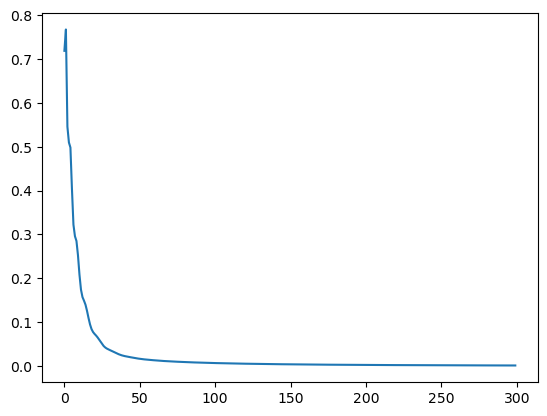

In [426]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []

for steps in range(300):
    optimizer.zero_grad(set_to_none=True)
    logits, loss = model(X_train, Y_train)
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

_, validation_loss = model(X_validation, Y_validation)
print(f"Loss: {loss.item()}")
print(f"Validation loss: {validation_loss.item()}")

import matplotlib.pyplot as plt
plt.plot(loss_values)


## Prediction

In [427]:
test_inputs = [
    "/usr/bin/node /pitcher/pitcher-agent.cjs containers exec run --id 4074f312-5bae-4d5a-97e1-1b8ca53d9b41 --workspace /project/sandbox --interactive --tty --verbose --command pnpm dev",
    "node index.js",
    "python main.py"
]
test_input_tensor = convert_lines_to_token_tensors(test_inputs)

with torch.no_grad():
    predictions, _loss = model(test_input_tensor)
    print(torch.round(predictions, decimals=3))
    

tensor([[0.9680],
        [0.0000],
        [0.0000]])
